In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.cross_validation import KFold

%matplotlib inline


In [3]:
gatrain = pd.read_csv('./data_ori/gender_age_train.csv')
gatest = pd.read_csv('./data_ori/gender_age_test.csv')
gatrain.head(3)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [4]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
n_classes = len(letarget.classes_)

In [5]:
pred = np.ones((gatrain.shape[0],n_classes))/n_classes

In [6]:
pred[0:5]

array([[ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333]])

In [7]:
log_loss(y, pred)


2.4849066497880012

In [8]:
kf = KFold(gatrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((gatrain.shape[0],n_classes))
for itrain, itest in kf:
    train = gatrain.iloc[itrain,:]
    test = gatrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    pred[itest,:] = prob.values
print(log_loss(y, pred))

2.42805122275


In [9]:
phone = pd.read_csv('./data_ori/phone_brand_device_model.csv',encoding='utf-8')
phone = phone.drop_duplicates('device_id', keep='first')
phone.head(3)

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4


In [10]:
lebrand = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = lebrand.transform(phone.phone_brand)
m = phone.phone_brand.str.cat(phone.device_model)
lemodel = LabelEncoder().fit(m)
phone['model'] = lemodel.transform(m)

ptrain = gatrain.merge(phone[['device_id','brand','model']], how='left',on='device_id')
ptrain.head(3)

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32-38,51,843
1,-2897161552818060146,M,35,M32-38,51,843
2,-8260683887967679142,M,35,M32-38,51,843


## Using Bayesian model
https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks/comments

In [11]:
class GenderAgeGroupProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        #self.label = 'pF_' + by
        self.prior = df['group'].value_counts().sort_index()/df.shape[0]
        # fit gender probs by grouping column
        c = df.groupby([by, 'group']).size().unstack().fillna(0)
        total = c.sum(axis=1)
        self.prob = (c.add(self.prior_weight*self.prior)).div(c.sum(axis=1)+self.prior_weight, axis=0)
        return self
    
    def predict_proba(self, df):
        pred = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.prob.columns]
        pred.loc[pred.iloc[:,0].isnull(),:] = self.prior
        return pred.values
    
def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

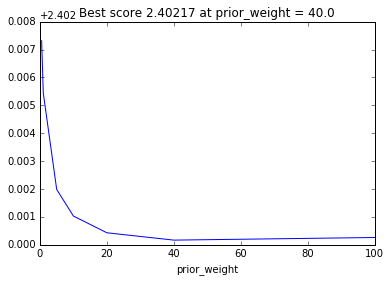

In [12]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

In [13]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)


2.3909032414810976

In [69]:
a, b = 1, 1.7
log_loss(y, (a*predb+b*predm)/(a+b))

2.3904026115503698

## Using XGBoost

In [14]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
params = {
    "objective": "multi:softprob",
    'booster': 'gbtree',
    'num_class': 12,
    "max_depth": 6,
    "eta": 0.1,
    "silent": 1,
    'n_estimators':10,
    'eval_metric': 'mlogloss'
}



In [20]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    ytrain, ytest = y[itrain], y[itest]
    xg_train = xgb.DMatrix( ptrain.iloc[itrain,[4,5]], label=ytrain)
    xg_test = xgb.DMatrix(ptrain.iloc[itest,[4,5]], label=ytest)
    watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
    bst = xgb.train(params, xg_train, 10, watchlist )
    pred[itest,:] = bst.predict(xg_test)


[0]	train-mlogloss:2.473808	test-mlogloss:2.474571
[1]	train-mlogloss:2.464059	test-mlogloss:2.465448
[2]	train-mlogloss:2.455399	test-mlogloss:2.457522
[3]	train-mlogloss:2.447795	test-mlogloss:2.450407
[4]	train-mlogloss:2.440967	test-mlogloss:2.444037
[5]	train-mlogloss:2.434904	test-mlogloss:2.438604
[6]	train-mlogloss:2.429422	test-mlogloss:2.433556
[7]	train-mlogloss:2.424562	test-mlogloss:2.429019
[8]	train-mlogloss:2.420187	test-mlogloss:2.425103
[9]	train-mlogloss:2.416175	test-mlogloss:2.421598
[0]	train-mlogloss:2.473752	test-mlogloss:2.475169
[1]	train-mlogloss:2.464079	test-mlogloss:2.466579
[2]	train-mlogloss:2.455343	test-mlogloss:2.459071
[3]	train-mlogloss:2.447482	test-mlogloss:2.452401
[4]	train-mlogloss:2.440520	test-mlogloss:2.446518
[5]	train-mlogloss:2.434479	test-mlogloss:2.441333
[6]	train-mlogloss:2.428946	test-mlogloss:2.436793
[7]	train-mlogloss:2.424055	test-mlogloss:2.432740
[8]	train-mlogloss:2.419625	test-mlogloss:2.429133
[9]	train-mlogloss:2.415669	tes

In [22]:
log_loss(y, pred)

2.4238074300339179

In [19]:

params = {
    "objective": "multi:softprob",
    'booster': 'gblinear',
    'num_class': 12,
    "max_depth": 6,
    "eta": 0.1,
    "silent": 1,
    'n_estimators':50,
    'eval_metric': 'mlogloss'
}
train_OH = pd.get_dummies(ptrain['brand'])
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    ytrain, ytest = y[itrain], y[itest]
    xg_train = xgb.DMatrix( train_OH.iloc[itrain, :], label=ytrain)
    xg_test = xgb.DMatrix(train_OH.iloc[itest, :], label=ytest)
    watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
    bst = xgb.train(params, xg_train, params['n_estimators'], watchlist )
    pred[itest,:] = bst.predict(xg_test)

[0]	train-mlogloss:2.469296	test-mlogloss:2.469649
[1]	train-mlogloss:2.457008	test-mlogloss:2.457277
[2]	train-mlogloss:2.446708	test-mlogloss:2.447241
[3]	train-mlogloss:2.438219	test-mlogloss:2.438977
[4]	train-mlogloss:2.431489	test-mlogloss:2.432176
[5]	train-mlogloss:2.425612	test-mlogloss:2.426560
[6]	train-mlogloss:2.420676	test-mlogloss:2.421919
[7]	train-mlogloss:2.416512	test-mlogloss:2.418033
[8]	train-mlogloss:2.413203	test-mlogloss:2.414834
[9]	train-mlogloss:2.410418	test-mlogloss:2.412149
[10]	train-mlogloss:2.407783	test-mlogloss:2.409916
[11]	train-mlogloss:2.405574	test-mlogloss:2.408045
[12]	train-mlogloss:2.403776	test-mlogloss:2.406508
[13]	train-mlogloss:2.402447	test-mlogloss:2.405182
[14]	train-mlogloss:2.401072	test-mlogloss:2.404083
[15]	train-mlogloss:2.399891	test-mlogloss:2.403194
[16]	train-mlogloss:2.398957	test-mlogloss:2.402459
[17]	train-mlogloss:2.397950	test-mlogloss:2.401835
[18]	train-mlogloss:2.397393	test-mlogloss:2.401325
[19]	train-mlogloss:2.

In [20]:
log_loss(y, pred)

2.4088601891406691

In [ ]:
train_OH = pd.concat([pd.get_dummies(ptrain['brand'], 'brand'), 
                      pd.get_dummies(ptrain['model'], 'model')], 
                      axis=1)

In [52]:
params = {
    "objective": "multi:softprob",
    'booster': 'gblinear',
    'num_class': 12,
    "max_depth": 9,
    "eta": 0.07,
    "silent": 1,
    'alpha':3,
    'lambda': 5,
    'n_estimators':50,
    'eval_metric': 'mlogloss'
}

kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred_x = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    ytrain, ytest = y[itrain], y[itest]
    xg_train = xgb.DMatrix( train_OH.iloc[itrain, :], label=ytrain)
    xg_test = xgb.DMatrix(train_OH.iloc[itest, :], label=ytest)
    watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
    bst = xgb.train(params, xg_train, params['n_estimators'], watchlist )
    pred_x[itest,:] = bst.predict(xg_test)

[0]	train-mlogloss:2.470063	test-mlogloss:2.470117
[1]	train-mlogloss:2.457670	test-mlogloss:2.457945
[2]	train-mlogloss:2.447284	test-mlogloss:2.447867
[3]	train-mlogloss:2.438639	test-mlogloss:2.439454
[4]	train-mlogloss:2.431374	test-mlogloss:2.432408
[5]	train-mlogloss:2.425125	test-mlogloss:2.426485
[6]	train-mlogloss:2.419862	test-mlogloss:2.421451
[7]	train-mlogloss:2.415331	test-mlogloss:2.417188
[8]	train-mlogloss:2.411482	test-mlogloss:2.413553
[9]	train-mlogloss:2.408103	test-mlogloss:2.410453
[10]	train-mlogloss:2.405169	test-mlogloss:2.407784
[11]	train-mlogloss:2.402710	test-mlogloss:2.405493
[12]	train-mlogloss:2.400457	test-mlogloss:2.403515
[13]	train-mlogloss:2.398503	test-mlogloss:2.401811
[14]	train-mlogloss:2.396936	test-mlogloss:2.400321
[15]	train-mlogloss:2.395351	test-mlogloss:2.399022
[16]	train-mlogloss:2.393909	test-mlogloss:2.397896
[17]	train-mlogloss:2.392762	test-mlogloss:2.396903
[18]	train-mlogloss:2.391737	test-mlogloss:2.396030
[19]	train-mlogloss:2.

In [53]:
log_loss(y, pred_x)

2.3955236896242953

In [104]:
pd.get_dummies(ptrain['brand']).head()

,1,2,3,4,5,6,7,8,9,10,...,121,122,123,124,125,126,127,128,129,130
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear regresion

In [29]:
from sklearn.linear_model import SGDClassifier

In [34]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred_l = np.zeros((ptrain.shape[0],n_classes))
c=1
for itrain, itest in kf:
    print('%d / %d' % (c, 10))
    ytrain, ytest = y[itrain], y[itest]
    xg_train = train_OH.iloc[itrain, :]
    xg_test = train_OH.iloc[itest, :]
    clf = SGDClassifier(loss='log')
    clf.fit(xg_train, ytrain)
    pred_l[itest,:] = clf.predict_proba(xg_test)
    c+=1
log_loss(y, pred_l)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


2.4012278752902065

In [49]:
log_loss(y, (3*predb + 3*predm + pred_x + pred_l)/8)

2.3903493892251553

## Adding features
Test the following features (may lead to overfitting as they are strongly correlated to brand name).
- String length
- Chinese or not
- Contains certains vowels

In [105]:
ptrain_p = train_OH
#ptrain_p['brand_len'] = phone['phone_brand'].str.len()
#ptrain_p['brand_chin'] = phone['phone_brand'].str.contains('[aeiouAEIOU]').astype(int)
#ptrain_p.fillna(0, inplace=True)

In [106]:
ptrain_p.head()

,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,...,model_1658,model_1659,model_1660,model_1661,model_1662,model_1664,model_1665,model_1666,brand_len,brand_chin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [107]:
params = {
    "objective": "multi:softprob",
    'booster': 'gblinear',
    'num_class': 12,
    "max_depth": 9,
    "eta": 0.07,
    "silent": 1,
    'alpha':3,
    'lambda': 5,
    'n_estimators':50,
    'eval_metric': 'mlogloss'
}

kf = KFold(ptrain_p.shape[0], n_folds=10, shuffle=True, random_state=0)
pred_x = np.zeros((ptrain_p.shape[0],n_classes))
for itrain, itest in kf:
    ytrain, ytest = y[itrain], y[itest]
    xg_train = xgb.DMatrix( ptrain_p.iloc[itrain, :], label=ytrain)
    xg_test = xgb.DMatrix(ptrain_p.iloc[itest, :], label=ytest)
    watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
    bst = xgb.train(params, xg_train, params['n_estimators'], watchlist )
    pred_x[itest,:] = bst.predict(xg_test)

[0]	train-mlogloss:2.466635	test-mlogloss:2.466447
[1]	train-mlogloss:2.452447	test-mlogloss:2.452196
[2]	train-mlogloss:2.441166	test-mlogloss:2.441037
[3]	train-mlogloss:2.432339	test-mlogloss:2.432215
[4]	train-mlogloss:2.425133	test-mlogloss:2.425157
[5]	train-mlogloss:2.419339	test-mlogloss:2.419457
[6]	train-mlogloss:2.414455	test-mlogloss:2.414836
[7]	train-mlogloss:2.410471	test-mlogloss:2.411040
[8]	train-mlogloss:2.407073	test-mlogloss:2.407917
[9]	train-mlogloss:2.404222	test-mlogloss:2.405307
[10]	train-mlogloss:2.401759	test-mlogloss:2.403136
[11]	train-mlogloss:2.399636	test-mlogloss:2.401293
[12]	train-mlogloss:2.397841	test-mlogloss:2.399728
[13]	train-mlogloss:2.396283	test-mlogloss:2.398396
[14]	train-mlogloss:2.394913	test-mlogloss:2.397250
[15]	train-mlogloss:2.393654	test-mlogloss:2.396253
[16]	train-mlogloss:2.392511	test-mlogloss:2.395390
[17]	train-mlogloss:2.391529	test-mlogloss:2.394639
[18]	train-mlogloss:2.390560	test-mlogloss:2.393970
[19]	train-mlogloss:2.

In [108]:
log_loss(y, pred_x)

2.3953549475390701

In [109]:
phone['phone_brand'].head()

0       小米
1       小米
2       三星
3    SUGAR
4       三星
Name: phone_brand, dtype: object

### Conclusion
- Result with columns: 2.3953549475390701
- Results without new columns: 2.3953549475390701
- This has no influence on outcome